In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [12]:
# load the data 
df = pd.read_csv('Data/engines2_data_cleaned_no_outliers.csv')

In [13]:
# Ensure df is a DataFrame
if isinstance(df, pd.DataFrame):
	# select the relevant columns
	X = df[['flight_cycle', 'flight_phase', 'egt_probe_average', 'fuel_flw', 'core_spd', 'zpn12p', 'vib_n1_#1_bearing', 'vib_n2_#1_bearing', 'vib_n2_turbine_frame']].copy()
else:
	raise TypeError("The variable 'df' is not a DataFrame. Please ensure it is properly defined.")
Y= df['RUL'].copy()

In [14]:
# getdummy for eng_number
X = pd.get_dummies(X, columns=['flight_phase'], drop_first=True)

In [15]:
# find min and max values for each column
min_values = X.min()
max_values = X.max()
# print min and max values
print("Minimum values:\n", min_values)
print("\nMaximum values:\n", max_values)


Minimum values:
 flight_cycle                 0
egt_probe_average       584.55
fuel_flw                1105.0
core_spd                 90.53
zpn12p                   51.74
vib_n1_#1_bearing          0.0
vib_n2_#1_bearing          0.0
vib_n2_turbine_frame       0.0
flight_phase_CRUISE      False
flight_phase_TAKEOFF     False
dtype: object

Maximum values:
 flight_cycle                4690
egt_probe_average       969.6375
fuel_flw                  5687.0
core_spd                  109.46
zpn12p                     91.08
vib_n1_#1_bearing            0.4
vib_n2_#1_bearing          1.225
vib_n2_turbine_frame        1.85
flight_phase_CRUISE         True
flight_phase_TAKEOFF        True
dtype: object


In [5]:
# Initial 80/20 split
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
# Further split temp into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Check the shapes of the splits
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (71035, 10), y_train shape: (71035,)
X_val shape: (8879, 10), y_val shape: (8879,)
X_test shape: (8880, 10), y_test shape: (8880,)


In [10]:
X_train.head()

,flight_cycle,egt_probe_average,fuel_flw,core_spd,zpn12p,vib_n1_#1_bearing,vib_n2_#1_bearing,vib_n2_turbine_frame,flight_phase_CRUISE,flight_phase_TAKEOFF
78969,975,834.150,1446.0,103.67,80.43,0.1333,0.100,0.400,False,True
8363,2792,840.875,1360.0,103.75,78.43,0.1267,0.350,0.400,False,True
50271,3571,901.400,5544.0,105.01,89.56,0.1000,0.150,0.150,False,False
58307,2476,857.975,2381.0,104.34,79.98,0.1000,0.700,1.300,False,True
1213,403,812.725,2784.0,102.72,77.68,0.0800,0.325,0.975,False,True


🧠 Multiple Models for Comparison

In [31]:
# Random Forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# model training with Random Forest and cross-validation for hyperparameter tuning

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [33]:
# Evaluate the model on the validation set
y_val_pred = best_rf.predict(X_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print(f"Validation MAE: {mae_val}, Validation RMSE: {rmse_val}")
r2_val = best_rf.score(X_val, y_val)
print(f"Validation R^2: {r2_val}")

Validation MAE: 105.75165446559296, Validation RMSE: 152.64188924672678
Validation R^2: 0.9845720609489328


In [34]:
# Evaluate the model on the test set
y_test_pred = best_rf.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print(f"Test MAE: {mae_test}, Test RMSE: {rmse_test}")
r2_test = best_rf.score(X_test, y_test)
print(f"Test R^2: {r2_test}")



Test MAE: 106.83426801801802, Test RMSE: 154.6724301666951
Test R^2: 0.983982282198074


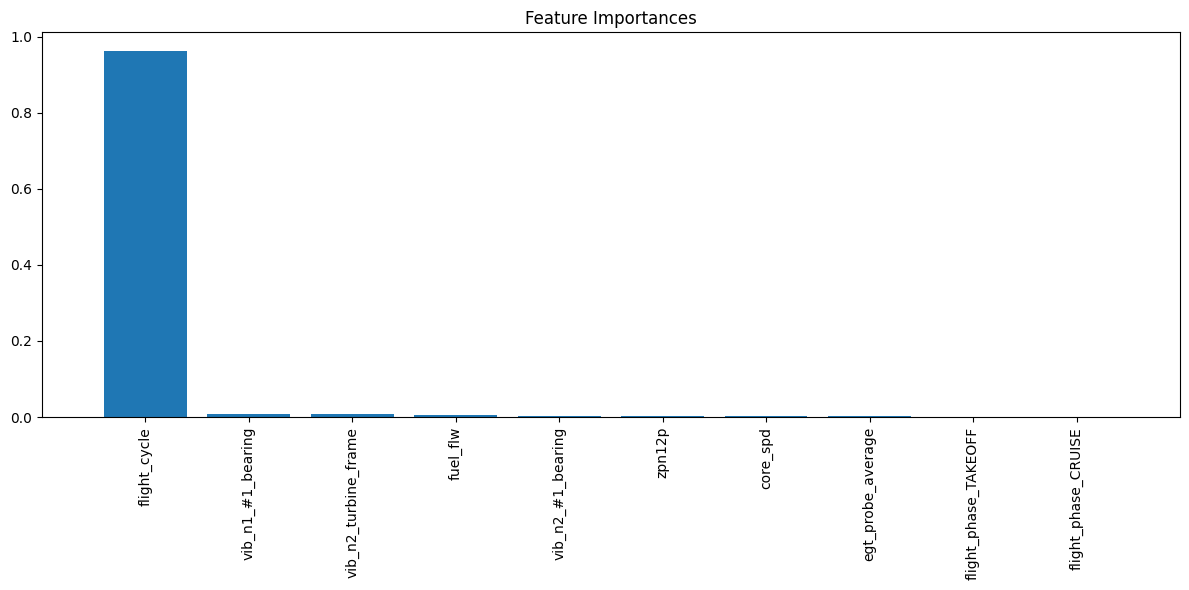

In [35]:
# Feature Importance
importances = best_rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.show()


In [11]:
# Save the model
import joblib
joblib.dump(best_rf, 'best_rf_model.pkl')


NameError: name 'best_rf' is not defined

In [6]:
# Try XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# model training with Random Forest and cross-validation for hyperparameter tuning
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [300],
}

xgb_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'n_estimators': 300}


In [7]:
# Evaluate the model on the validation set
y_val_pred = best_xgb.predict(X_val_scaled)
mae_val = mean_absolute_error(y_val, y_val_pred)    
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print(f"Validation MAE: {mae_val}, Validation RMSE: {rmse_val}")
r2_val = r2_score(y_val, y_val_pred)
print(f"Validation R^2: {r2_val}")



Validation MAE: 114.23770207700355, Validation RMSE: 154.08857028676283
Validation R^2: 0.9842782350021987


In [8]:
# Evaluate the model on the test set
y_test_pred = best_xgb.predict(X_test_scaled)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print(f"Test MAE: {mae_test}, Test RMSE: {rmse_test}")
r2_test = r2_score(y_test, y_test_pred)
print(f"Test R^2: {r2_test}")


Test MAE: 116.20105980277599, Test RMSE: 156.5320114569919
Test R^2: 0.9835948142573191


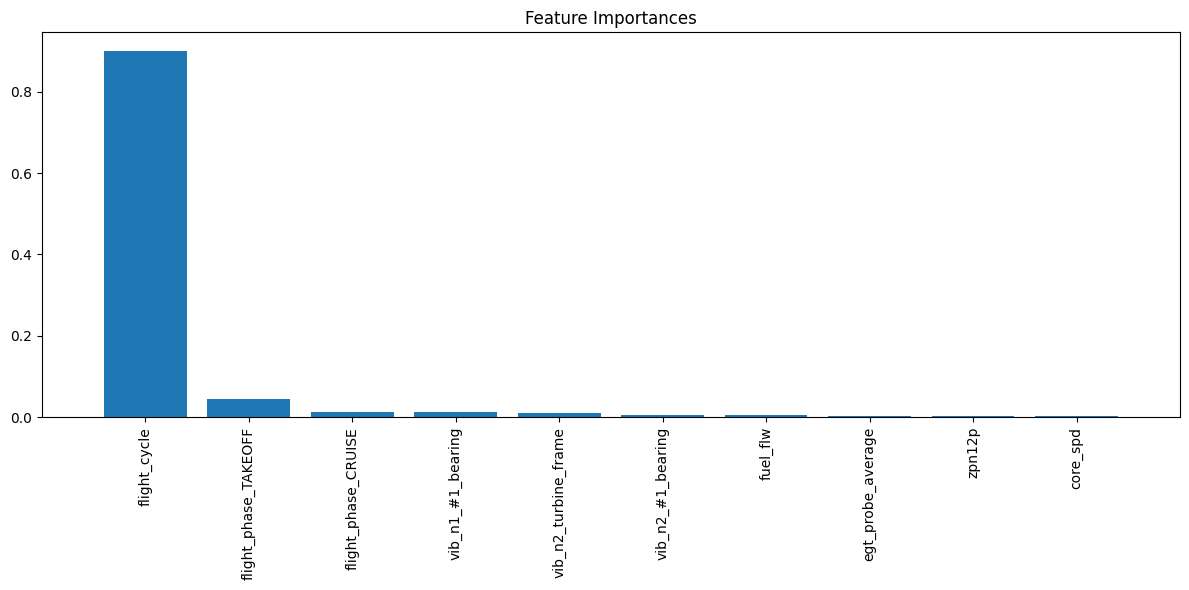

In [9]:
# Feature Importance
importances = best_xgb.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.savefig('feature_importances_xgb.png')
plt.show()


In [12]:
# Save the model
import joblib
joblib.dump(best_xgb, 'best_xgb_model.pkl')
# Save the scaler
joblib.dump(scaler, 'scale_xgb.pkl')

['scale_xgb.pkl']